# LoopGAN — Loop generation with StyleGAN2 and MelGAN

In [1]:
import argparse
import torch
from torchvision import utils
from model_drum import Generator
import sys
sys.path.append('./melgan')
from modules import Generator_melgan
import os, random
import librosa, librosa.display
import soundfile as sf
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import IPython.display as ipd

### Download a pre-trained model in advance

``` 
$ gdown -O drumbeats1_230000.pt 1VL7kfHGMTcpniZllKZtNnN1inT9AsNzu
```

In [2]:
import os

# Use the Windows temporary directory
temp_dir = os.getenv('TEMP')

# Saving the generated spectrogram image
randid = random.randint(0, 10000)
imagepath = os.path.join(temp_dir, f'img_{randid}.png')
filepath = os.path.join(temp_dir, f'gem_{randid}.wav')

# Ensure the paths are correct
print(f"Image path: {imagepath}, Audio path: {filepath}")

Image path: C:\Users\anecoica\AppData\Local\Temp\img_4114.png, Audio path: C:\Users\anecoica\AppData\Local\Temp\gem_4114.wav


In [3]:

# Constants - do not change! 
N_LATENT = 512
N_MLP = 8
SIZE_OUTPUT = 64 # size of output image
TRUNCATION = 1 # if this is >=1, then no truncation
VARIATION  = 0.1
TRUNCATION_MEAN = 4096 # # of samples for getting mean latent
SR = 44100

# Number of samples (loops) in a batch
n_samples = 4  # batch size

# name of pre-trained StyleGAN2 model
CHECKPOINT = "./drumbeats1_230000.pt" 

# mean / std of Spectrograms of training data. used for the conversion from generated spectrograms into wav files
DATAPATH = "./data/drumbeats_1bar/" 

# name of pre-trained MelGAN model
MELGAN_MODEL_NAME = "best_netG.pt"

# GANSpace - # of PCA components
N_PCA_COMPS = 6

# Use "cuda" if you have GPUs on your machine
device_name = "cuda" if torch.cuda.is_available() else "cpu"
print(device_name)


cuda


### Load models

In [4]:
# Load a StyleGAN2 model
generator = Generator(SIZE_OUTPUT, N_LATENT, N_MLP, channel_multiplier=2).to(device_name)
checkpoint = torch.load(CHECKPOINT, map_location=torch.device(device_name))

generator.load_state_dict(checkpoint["g_ema"], strict=False)

# Global reference for the generator
g_ema = generator
g_ema.eval()  # Set the generator to evaluation mode
mean_latent = None  # Initially set it to None

if TRUNCATION < 1:
    with torch.no_grad():
        mean_latent = generator.mean_latent(TRUNCATION_MEAN)
else:
    mean_latent = None

w1, w2, inject_index = None, None, None

C:\Users\anecoica\AppData\Local\Temp\ipykernel_10732\3248681865.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT, map_location=torch.de

In [5]:
# Load a MelGAN model
def load_vocoder(device_name):
    feat_dim = 80
    mean_fp = f'{DATAPATH}/mean.mel.npy'
    std_fp = f'{DATAPATH}/std.mel.npy'
    v_mean = torch.from_numpy(np.load(mean_fp)).float().view(1, feat_dim, 1).to(device_name)
    v_std = torch.from_numpy(np.load(std_fp)).float().view(1, feat_dim, 1).to(device_name)
    
    vocoder_config_fp = './melgan/args.yml'
    vocoder_config = read_yaml(vocoder_config_fp)

    n_mel_channels = vocoder_config.n_mel_channels
    ngf = vocoder_config.ngf
    n_residual_layers = vocoder_config.n_residual_layers

    vocoder = Generator_melgan(n_mel_channels, ngf, n_residual_layers).to(device_name)
    vocoder.eval()

    vocoder_param_fp = os.path.join('./melgan', MELGAN_MODEL_NAME)
    vocoder.load_state_dict(torch.load(vocoder_param_fp, map_location=torch.device(device_name)), strict=False)

    return vocoder, v_mean, v_std

VOCODER, V_MEAN, V_STD = load_vocoder(device_name)

def vocode(sample, vocoder=VOCODER, v_mean=V_MEAN, v_std=V_STD):
    de_norm = sample.squeeze(0) * v_std + v_mean
    audio_output = vocoder(de_norm)
    return audio_output

c:\Users\anecoica\miniconda3\envs\loopgan\lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\anecoica\AppData\Local\Temp\ipykernel_10732\4169813888.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend y

# GANSpace 

PCA on randomly generated W vectors to get meaningful style vector directions.

Härkönen, Erik, Aaron Hertzmann, Jaakko Lehtinen, and Sylvain Paris. 2020. “GANSpace: Discovering Interpretable GAN Controls.” arXiv [cs.CV]. arXiv. http://arxiv.org/abs/2004.02546.


Explained Variance:  [0.12987024 0.08943579 0.0815466  0.03513855 0.02195785 0.02127705]


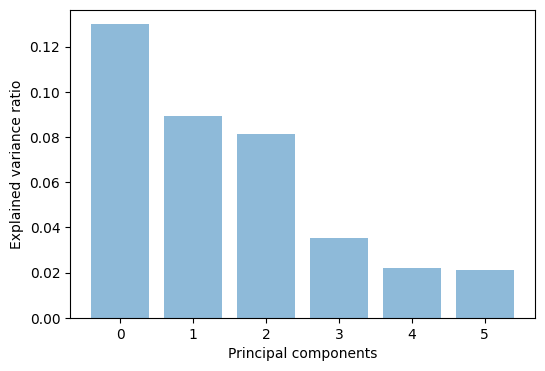

How many PCA components we need?


In [6]:
from sklearn.decomposition import PCA

# Generate random W (style vectors) with random Z 
randz = torch.randn(2000, N_LATENT, device=device_name) 
randw = generator.get_latent(randz).detach().cpu().numpy()

# Find principal components using PCA 
pca = PCA(n_components=N_PCA_COMPS)
pca.fit(randw)
pcomponents = torch.tensor(pca.components_) # PCA components

# Explained variance
explained_variance = pca.explained_variance_ratio_
print('Explained Variance: ', explained_variance)

# Scree plot
plt.figure(figsize=(6, 4))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()
print("How many PCA components we need?")

# probably 6 components are enough

### Generation

To make it easier to handle on Max/MSP, generated loops is saved as a wav file with `n_samples` channels. (default: 4ch)

In [7]:
from pydub import AudioSegment
import os
prev_w = None

# Adde PCAed W vector
def get_w(w, coefs, scale=1.0):
    coefs = coefs[:N_PCA_COMPS]  # Limit to N_PCA_COMPS
    coefs_tensor = torch.tensor([coefs], device=device_name)  # Create tensor for coefficients
    pcomponents_device = pcomponents.to(device_name)  # Ensure PCA components are on the right device
    w_diff = pcomponents_device * coefs_tensor.T  # Multiply by PCA components
    
    # Add weighted PCA components to each latent vector in the batch
    w += w_diff.sum(0)  # Sum the contributions of all PCA components

    return w


# main function
# g_ema: stylegan generator
# center_z: to specify the input latent z 
# trucation: GAN trucation value
# variation: the scale of noise added to center_z (= vatiation in a batch)
def generate(g_ema=generator, 
             w1=None,  
             w2=None,  
             inject_index=None,  
             center_z=None, 
             use_prev_w=False, 
             truncation=TRUNCATION, 
             variation=VARIATION, 
             coef=None,
             noise=None):

    global prev_w  # Maintain global state across cells
    device = torch.device(device_name)
    print("generating...")
    g_ema = g_ema.to(device)

    with torch.no_grad():
        g_ema.eval()

        # Style mixing logic: If w1 and w2 are provided, perform style mixing
        if w1 is not None and w2 is not None:
            w1, w2 = w1.to(device), w2.to(device)
            if inject_index is None:
                inject_index = random.randint(1, g_ema.n_latent - 1)
            # Interpolation between w1 and w2 controlled by t
            if t is not None:
                mixed_w = t * w1 + (1 - t) * w2
                latent = mixed_w.unsqueeze(1).repeat(1, g_ema.n_latent, 1)
            else:
                latent = w1.unsqueeze(1).repeat(1, inject_index, 1)
                latent2 = w2.unsqueeze(1).repeat(1, g_ema.n_latent - inject_index, 1)
                latent = torch.cat([latent, latent2], 1).to(device)

        else:
            # Generate latent vector from Z if w1 and w2 are not provided
            if not use_prev_w or prev_w is None:
                if center_z is None:
                    sample_z = torch.randn(1, N_LATENT, device=device)
                    sample_z = sample_z.repeat(n_samples, 1) + torch.randn(n_samples, N_LATENT, device=device) * variation
                else:
                    sample_z = center_z + torch.randn(n_samples, N_LATENT, device=device) * variation
                latent = g_ema.get_latent(sample_z).unsqueeze(1).repeat(1, g_ema.n_latent, 1).to(device)
                prev_w = latent.clone()
            else:
                if prev_w.dim() == 2:  # Ensure prev_w has two dimensions (batch_size, latent_dim)
                    latent = prev_w.unsqueeze(1).repeat(1, g_ema.n_latent, 1).to(device)
                else:
                    latent = prev_w  # Use it as-is if already in the correct format

        # Apply PCA coefficients if available
        if coef:
            latent = get_w(latent, coef)

        # Apply truncation if necessary
        if truncation < 1 and mean_latent is not None:
            latent = truncation * (latent - mean_latent.to(device)) + mean_latent.to(device)

        # Forward pass through generator
        sample, _ = g_ema([latent], truncation=truncation, truncation_latent=mean_latent, input_is_latent=True, noise=noise)

        # If the generated sample is smaller than expected, ensure at least one sample is handled
        if sample.size(0) < n_samples:
            sample = sample.repeat(n_samples, 1, 1, 1)

        # Save and return outputs
        temp_dir = os.getenv('TEMP')
        randid = random.randint(0, 10000)
        imagepath = os.path.join(temp_dir, f'img_{randid}.png')
        filepath = os.path.join(temp_dir, f'gem_{randid}.wav')

        utils.save_image(sample, imagepath, nrow=1, normalize=True, value_range=(-1, 1))

        # Saving multi-channel audio file
        channels = []
        numpy_chs = []
        for i in range(min(n_samples, sample.size(0))):  # Ensure we're not indexing out of bounds
            audio_output = vocode(sample[i])
            audio_output = audio_output.squeeze().detach().cpu().numpy()
            numpy_chs.append(audio_output)
            channel = AudioSegment((audio_output * np.iinfo(np.int16).max).astype("int16").tobytes(),
                                   sample_width=2,  # 16 bit
                                   frame_rate=SR, channels=1)
            channels.append(channel)

        multich = AudioSegment.from_mono_audiosegments(*channels)
        multich.export(filepath, format="wav")

        return filepath, imagepath, np.array(numpy_chs)





### Test

Let's generate random loops with random input latent z

generating...


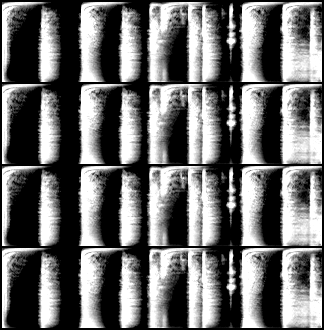

In [8]:
# random generation 
_,  imagepath, audio_output = generate(variation=0.0)

# display the generated spectrogram
ipd.display(ipd.Image(filename=imagepath))


# play the first channel
ipd.display(ipd.Audio(audio_output[0], rate=SR))

# GANSpace Inrterpolation
interpolation of the first PCA components

In [9]:
# baseline
print("baseline rhythm")
_,  imagepath, audio_output = generate(variation=0.0)
ipd.display(ipd.Audio(audio_output[0], rate=SR))
print("------------")
print("\n")

# changing the 1st component
print("changing the 1st PCA component")
#for x in np.linspace(-10, 10, 7):
#    _, _, audio_output  = generate(center_z=None, use_prev_w=True, coef = [x,0,0,0,0,0]) 
#    print("1st component:", x)
#    ipd.display(ipd.Audio(audio_output[0], rate=SR))

baseline rhythm
generating...


------------


changing the 1st PCA component


#### Stereo effect
Small gausian noise can be added to the input latent vector z. If you play the first and second sample in the generated batch as a stereo audio file, then you'll get an interesting stereo effect. Try different numbers! 

generating...


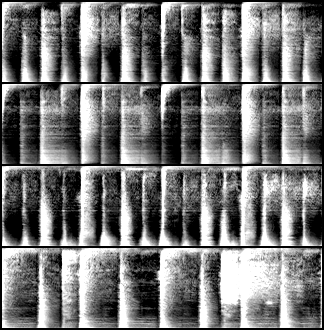

In [10]:
_,  imagepath, audio_output = generate(variation=0.35)

ipd.display(ipd.Audio(audio_output[:2], rate=SR)) # stereo 

ipd.display(ipd.Image(filename=imagepath))


### OSC server/client for Max/MSP

In [11]:
# test
audiopath, imagepath, _ = generate(center_z=None, use_prev_w=False, truncation=1.0, variation=0.1, coef=[0, 0, 0, 0, 0, 0])
print(f"Audio path: {audiopath}, Image path: {imagepath}")


generating...
Audio path: C:\Users\anecoica\AppData\Local\Temp\gem_6789.wav, Image path: C:\Users\anecoica\AppData\Local\Temp\img_6789.png


In [12]:
from pythonosc import dispatcher
from pythonosc import osc_server, udp_client
import os, random

# client
client = udp_client.SimpleUDPClient('127.0.0.1', 10018)
variation = 0.10
truncation = 1.0
coef = [0, 0, 0, 0, 0, 0]  # Default PCA coefficients

# OSC handler to update variation
def set_variation(unused_addr, variation_value):
    global variation
    variation = variation_value
    print(f"Variation set to: {variation}")

# OSC handler to update truncation
def set_truncation(unused_addr, truncation_value):
    global truncation
    truncation = truncation_value
    print(f"Truncation set to: {truncation}")

# OSC handler to update PCA coefficients
def set_coefficients(unused_addr, *coefficients):
    global coef
    coef = list(coefficients)[:6]  # Ensure only 6 values
    print(f"PCA coefficients set to: {coef}")
# generate randomly
def generate_random(unused_addr, x1, x2, x3, x4, x5, x6, variation, truncation):
    global mean_latent, g_ema
    print(f"Received: x1={x1}, x2={x2}, ..., variation={variation}, truncation={truncation}")
    
    # Initialize mean_latent for truncation if needed
    if truncation < 1 and mean_latent is None:
        mean_latent = g_ema.mean_latent(TRUNCATION_MEAN)

    # Set use_prev_w to False to ensure fresh random Z
    print("Generating random sample...")
    audiopath, imagepath, _ = generate(center_z=None, 
                                       use_prev_w=False,  # Force new random latent vectors
                                       truncation=truncation,
                                       variation=variation, 
                                       coef=[x1, x2, x3, x4, x5, x6])  # PCA coefficients
    
    print(f"Generated audio: {audiopath}, image: {imagepath}")

    client.send_message("/generated", (audiopath, imagepath))
    print("Message sent to Max")



# morphing
def generate_xy(unused_addr, x1,x2,x3,x4,x5,x6, variation, truncation):
    global mean_latent, g_ema
    print(f"Received: x1={x1}, x2={x2}, ..., variation={variation}, truncation={truncation}")
    # Initialize mean_latent for truncation if needed
    if truncation < 1 and mean_latent is None:
        mean_latent = g_ema.mean_latent(TRUNCATION_MEAN)
    print("Generating random sample...")     
    audiopath, imagepath, _  = generate(center_z=None, 
                                        use_prev_w=True,
                                        truncation=truncation,
                                        variation=variation, 
                                        coef = [x1,x2,x3,x4,x5,x6]) # random sample
    print(f"Generated audio: {audiopath}, image: {imagepath}")
    client.send_message("/generated", (audiopath, imagepath))
    print("Message sent to Max")

# Style mixing function for generating mixed outputs
def generate_mixed(unused_addr, *coefficients):
    global mean_latent, g_ema, w1, w2, inject_index

    # Ensure that generator and necessary variables are initialized
    if g_ema is None:
        print("Error: g_ema is not initialized")
        return
    
    if w1 is None or w2 is None or inject_index is None:
        print("Error: W1, W2, or inject_index not set")
        return

    print(f"Using W1 ({w1.size(1)}) and W2 ({w2.size(1)}) for style mixing with inject_index {inject_index}")
    
    # Call the generate function with w1 and w2 for style mixing
    audiopath, imagepath, _ = generate(w1=w1, w2=w2, inject_index=inject_index, truncation=truncation)

    # Send the generated audio and image paths back to the client
    client.send_message("/generated", (audiopath, imagepath))
    print(f"Generated mixed output: {audiopath}, {imagepath}")


# OSC Handlers for W1 and W2
w1_part1, w1_part2, w2_part1, w2_part2 = None, None, None, None

# Handle W1 parts (split into two 256-value parts)
def set_w1_part1(unused_addr, *w1_values):
    global w1_part1
    if len(w1_values) == 256:
        w1_part1 = list(w1_values)
        print("W1 part 1 set")
    else:
        print(f"Expected 256 values, received {len(w1_values)}")

def set_w1_part2(unused_addr, *w1_values):
    global w1_part1, w1_part2, w1
    if len(w1_values) == 256:
        w1_part2 = list(w1_values)
        print("W1 part 2 set")
        # Ensure both parts are received and not None
        if w1_part1 is not None and w1_part2 is not None:
            w1_combined = w1_part1 + w1_part2
            w1 = torch.tensor(w1_combined, dtype=torch.float32).view(1, 512).to(device_name)
            print("W1 fully set")
            # Reset parts after combining
            w1_part1 = None
            w1_part2 = None
    else:
        print(f"Expected 256 values, received {len(w1_values)}")

# Handle W2 parts
def set_w2_part1(unused_addr, *w2_values):
    global w2_part1
    if len(w2_values) == 256:
        w2_part1 = list(w2_values)
        print("W2 part 1 set")
    else:
        print(f"Expected 256 values, received {len(w2_values)}")

def set_w2_part2(unused_addr, *w2_values):
    global w2_part1, w2_part2, w2
    if len(w2_values) == 256:
        w2_part2 = list(w2_values)
        print("W2 part 2 set")
        # Ensure both parts are received and not None
        if w2_part1 is not None and w2_part2 is not None:
            w2_combined = w2_part1 + w2_part2
            w2 = torch.tensor(w2_combined, dtype=torch.float32).view(1, 512).to(device_name)
            print("W2 fully set")
            # Reset parts after combining
            w2_part1 = None
            w2_part2 = None
    else:
        print(f"Expected 256 values, received {len(w2_values)}")

# Handle inject_index
def set_inject_index(unused_addr, index):
    global inject_index
    inject_index = int(index)
    print(f"Inject index set to {inject_index}")

# OSC Dispatcher Setup
dispatcher = dispatcher.Dispatcher()
dispatcher.map("/set_variation", set_variation)
dispatcher.map("/set_truncation", set_truncation)
dispatcher.map("/set_coefficients", set_coefficients)
dispatcher.map("/generate_random", generate_random)
dispatcher.map("/generate_xy", generate_xy)
dispatcher.map("/set_w1_part1", set_w1_part1)
dispatcher.map("/set_w1_part2", set_w1_part2)
dispatcher.map("/set_w2_part1", set_w2_part1)
dispatcher.map("/set_w2_part2", set_w2_part2)
dispatcher.map("/set_inject_index", set_inject_index)
dispatcher.map("/generate_mixed", generate_mixed)

# OSC Server Setup
server = osc_server.ThreadingOSCUDPServer(('localhost', 10015), dispatcher)
print(f"Serving on {server.server_address}")

try:
    while True:
        server.handle_request()
except KeyboardInterrupt:
    print("Server stopped.")



Serving on ('127.0.0.1', 10015)
Error: W1, W2, or inject_index not set
W1 part 2 set
W1 part 1 set
Error: W1, W2, or inject_index not set
W1 part 2 set
W1 fully set
W1 part 1 set
Error: W1, W2, or inject_index not set
W1 part 2 set
W1 fully set
W1 part 1 set
Error: W1, W2, or inject_index not set
W2 part 2 set
W2 part 1 set
Error: W1, W2, or inject_index not set
W2 part 2 set
W2 fully set
W2 part 1 set
Error: W1, W2, or inject_index not set
Inject index set to 4
W2 part 2 set
W2 fully set
W2 part 1 set
W1 part 2 set
W1 fully set
W1 part 1 set
Using W1 (512) and W2 (512) for style mixing with inject_index 4
generating...
Generated mixed output: C:\Users\anecoica\AppData\Local\Temp\gem_2686.wav, C:\Users\anecoica\AppData\Local\Temp\img_2686.png
W1 part 2 set
W1 fully set
W1 part 1 set
Using W1 (512) and W2 (512) for style mixing with inject_index 4
generating...
Generated mixed output: C:\Users\anecoica\AppData\Local\Temp\gem_9320.wav, C:\Users\anecoica\AppData\Local\Temp\img_9320.png
W2